<a href="https://colab.research.google.com/github/Sina-Haz/Generative-Modelling/blob/main/Score-Based-Models/score_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as np
from jax.scipy.stats import norm
from jax import grad, vmap
import matplotlib.pyplot as plt
import seaborn as sns
import equinox as eqx


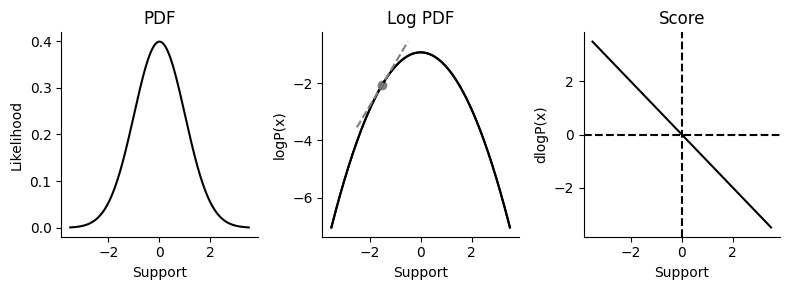

In [ ]:
fig, axes = plt.subplots(figsize=(8, 3), nrows=1, ncols=3, sharex=True)

plt.sca(axes[0])
x = np.linspace(-3.5, 3.5, 1000)
y = norm.pdf(x)
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("Likelihood")
plt.title("PDF")
sns.despine()

y = norm.logpdf(x)
plt.sca(axes[1])
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("logP(x)")
plt.title("Log PDF")

# Tangent Line
def line(x):
    return grad(norm.logpdf)(x_pt) * (x - x_pt) + y_pt
x_pt = -1.5
y_pt = norm.logpdf(x_pt)
xrange = np.linspace(x_pt - 1, x_pt + 1, 10)
plt.plot(x, y, color="black")
plt.scatter(x_pt, y_pt, color="gray")
plt.plot(xrange, vmap(line)(xrange), color="gray", ls="--")


plt.sca(axes[2])
plt.plot(x, vmap(grad(norm.logpdf))(x), color="black")
plt.axhline(y=0, ls="--", color="black")
plt.axvline(x=0, ls="--", color="black")
plt.xlabel("Support")
plt.ylabel("dlogP(x)")
plt.title("Score")

sns.despine()
plt.tight_layout()

In [ ]:
# Get gaussian score and assert that for normal standard its just -x
gaussian_score = grad(norm.logpdf)
gaussian_score(-4.), gaussian_score(0.), gaussian_score(4.)

(Array(4., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(-4., dtype=float32, weak_type=True))

In [ ]:
from jax import random

# Define our distribution as normal(mu = 3, sigma = 1)
key = random.PRNGKey(44)
true_mu, true_sigma = 3, 1
data = random.normal(key, shape=(1000,1)) * true_sigma + true_mu

In [ ]:
# Let's make a gaussian model
from jax import jacfwd

class GaussianScoreModel(eqx.Module):
  mu: np.array = np.array(0.0)
  log_sigma: np.array = np.array(0.0)

  @eqx.filter_jit
  def __call__(self, x):
    score = jacfwd(norm.logpdf)
    return score(x, loc=self.mu, scale=np.exp(self.log_sigma))


model = GaussianScoreModel()
model(-3.), model(0.), model(3.)

(Array(3., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(-3., dtype=float32, weak_type=True))

In [ ]:
# Lets make sure we can call this model over all of the data, squeeze this b/c resulting output is 3D tensor
data_score = vmap(model)(data).squeeze()

data_score[0:3], data.mean(), data.std()

(Array([-0.8219464, -3.8602278, -1.4089172], dtype=float32),
 Array(2.9986677, dtype=float32),
 Array(1.0197434, dtype=float32))

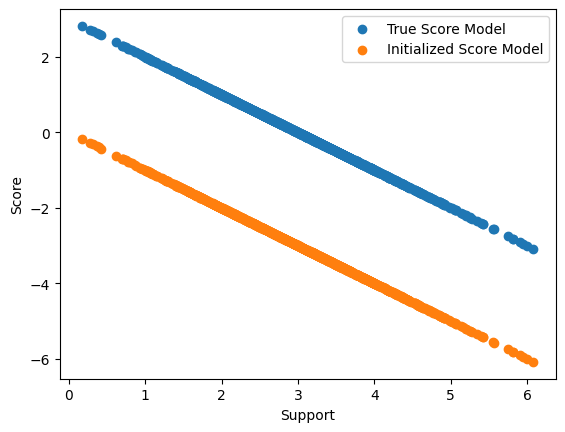

In [ ]:
# Let's see what the actual scores vs. our untrained scores look like

true_model = GaussianScoreModel(mu=true_mu, log_sigma=np.log(true_sigma))
true_model_scores = vmap(true_model)(data)
plt.scatter(data.squeeze(), true_model_scores.squeeze(), label="True Score Model")
plt.scatter(data.squeeze(), data_score.squeeze(), label="Initialized Score Model")
plt.xlabel("Support")
plt.ylabel("Score")
plt.legend();

In [ ]:
# Implement score matching loss to train our gaussian model with gradient descent
print(data.shape)

from typing import Callable, List, Tuple
import optax
from tqdm.auto import tqdm

def score_matching_loss(model, data):
  '''
  data should have shape (batch, :), at least a 2D tensor
  '''
  # Compute the hessians of the logpdf (or jacobian of score fn)
  hess = vmap(jacfwd(model))(data)

  # Get the diagonals of the Hessians, correspond to derivative of score fn w.r.t. i-th data dimension
  # If it's a 2D tensor, add another dimension so that when we call np.diagonal it reduces dim instead of increasing it
  if hess.shape[-1] == 1 and len(hess.shape)==2:
    hess = np.expand_dims(hess, -1)
  term1 = vmap(np.diagonal)(hess)

  term2 = 0.5 * vmap(model)(data)**2
  term2 = np.reshape(term2, term1.shape) # reshape to be like term 1

  inner = term1 + term2
  # sum along data dimensions (mapping np.sum to each individual data tensor ensures final shape is (batch, ))
  inner = vmap(np.sum)(inner)

  # Now average over the entire batch of data
  loss = np.mean(inner)
  return loss

def fit(
    model: eqx.Module,
    data: np.array,
    loss_fn: Callable,
    optimizer: optax.GradientTransformation,
    steps: int,
    progress_bar: bool = True,
  ) -> Tuple[List[eqx.Module], List]:
  """
  Fit model to data

  data should have shape (batch, :), at least a 2D tensor

  returns updated model + loss training history
  """
  # Set up the state of the optimizer, filtering for weights which are inexact (which is apparently anything that is floating point)
  opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

  # Here we call filter_value_and_grad s.t. it returns pair (value, grad). We jit compile it too to be faster
  dloss = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))

  @eqx.filter_jit
  def step(model, opt_state, data):
    """
    One step of training loop, jitted to run faster
    """

    loss, grads = dloss(model, data)

    # Next we compute the updates and obtain optimizer state
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply updates to the model
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

  loss_hist = []
  iterator = range(steps)
  if progress_bar: iterator = tqdm(iterator)

  for _ in iterator:
    model, opt_state, loss = step(model, opt_state, data)
    loss_hist.append(loss)
  return model, loss_hist

score_matching_loss(model, data)

(1000, 1)


Array(4.015941, dtype=float32)

In [ ]:
# Now let's train the model
opt = optax.adam(learning_rate=5e-3)
updated_model, loss_hist = fit(model, data, score_matching_loss, opt, 2000, progress_bar=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

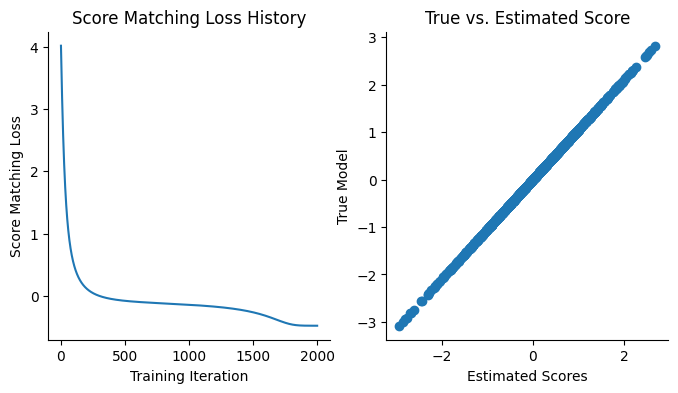

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)


plt.sca(axes[0])
plt.plot(loss_hist)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data)
plt.scatter(updated_model_scores.squeeze(), true_model_scores.squeeze())
plt.xlabel("Estimated Scores")
plt.ylabel("True Model")
plt.title("True vs. Estimated Score");

In [ ]:
np.mean(data), np.std(data), updated_model.mu, np.exp(updated_model.log_sigma)

(Array(2.9986677, dtype=float32),
 Array(1.0197434, dtype=float32),
 Array(2.9963465, dtype=float32),
 Array(1.0235366, dtype=float32))

In [ ]:
# So clearly the loss function seems to work for our gaussian model, but what if now we assume we don't know the form of the logpdf
# and instead try to approximate score function via MLP?
from jax.tree_util import tree_flatten, tree_map

mlp = eqx.nn.MLP(
    in_size = 1,
    out_size = 1,
    width_size = 1024,
    depth=1,
    key=random.PRNGKey(45)
)

def regularized_loss(model, data):
  sm_loss = score_matching_loss(model, data)

  # compute l2 norm
  params = eqx.filter(model, eqx.is_array_like)
  squared = tree_map(lambda x: np.power(x, 2), params)
  summed = tree_map(np.sum, squared)
  flattened, _ = tree_flatten(summed)

  l2_norm = np.mean(np.array(flattened)) * 0.1 # scale it down too

  return sm_loss + l2_norm

In [ ]:
optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3),
)

updated_mlp, history = fit(
    mlp,
    data,
    regularized_loss,
    optimizer,
    steps=2_000,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

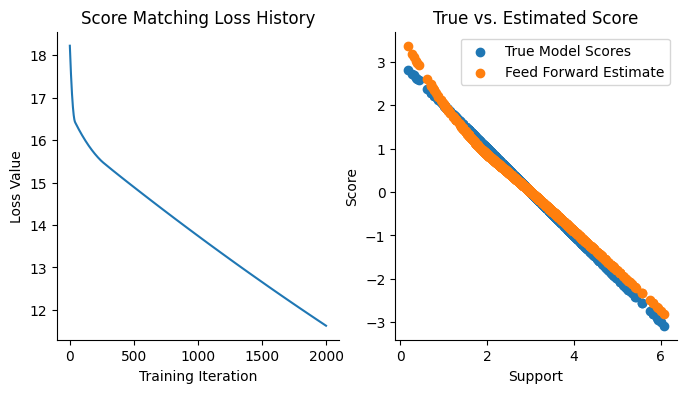

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(history)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_mlp)(data).squeeze()
plt.scatter(data.squeeze(), true_model_scores, label="True Model Scores")
plt.scatter(data.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend();